In [1]:
import ee
import datetime
import os
import itertools
import sys
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE
import ast

In [2]:
ee.Initialize()

In [3]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('..')

In [4]:
from BackGround_modules.Class_2_Classify_Fourier_Img   import Classification
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment

##### Prepare basic parameters

In [5]:
# define the years to be classified
year_name  = [f'{i}_{i+2}' for i in range(1990,2020,3)]

# define the number of total periods
num_invarient = 10

# import north_china_plain boundary
North_China_Plain = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

In [6]:
year_name

['1990_1992',
 '1993_1995',
 '1996_1998',
 '1999_2001',
 '2002_2004',
 '2005_2007',
 '2008_2010',
 '2011_2013',
 '2014_2016',
 '2017_2019']

##### Prepare input_image for classification

In [7]:
# import Landsat img
Landsat_img = [ee.Image(f"users/wang8052664/Cloud_Free_Img/Landsat_cloud_free_{year}")\
                 .clip(North_China_Plain)  for year in year_name]

# import Fourier img   
Fourier_img = [ee.Image(f"users/Jinzhu_Deakin/North_China_Plain/Fourier_img_harmonic_3/Fourier_img_{year}_harmonic_3")\
                 .clip(North_China_Plain)  for year in year_name[:5]] + \
              [ee.Image(f"users/wang8052664/North_China_Plain/Fourier_imgs/Fourier_img_{year}_harmonic_3")\
                 .clip(North_China_Plain)  for year in year_name[5:]] 

# Import the Index-mean Img
NDVI_img = [ee.Image(f"users/wensomone666/Jinzhu/Mean_NDVI/Year_{year}_Mean_NDVI").rename('Mean_NDVI')  
            for year in year_name ]
NDBI_img = [ee.Image(f"users/wensomone666/Jinzhu/Mean_NDVI/Year_{year}_Mean_NDBI").rename('Mean_NDBI')  
            for year in year_name ]
EVI_img  = [ee.Image(f"users/wensomone666/Jinzhu/Mean_NDVI/Year_{year}_Mean_EVI").rename('Mean_EVI')  
            for year in year_name ]

# prepare the climate data
Climate_mean = [ee.Image(f"users/wangjinzhulala/North_China_Plain_Python/Climate_data/Mean_{year}")
               .clip(North_China_Plain)  for year in year_name]

# Import DEM/SLOPE Img
DEM   = [ee.Image("USGS/SRTMGL1_003").rename('DEM')] * num_invarient
SLOPE = [ee.Terrain.slope(DEM).rename('SLOPE')] * num_invarient

In [8]:
# stack all Imput_Img together
Stack_img = [ee.Image(img) for img in zip(Landsat_img,Fourier_img,NDVI_img,NDBI_img,EVI_img,Climate_mean,DEM,SLOPE)]

##### Prepare input sample points

In [9]:
# Define the path to Sample_pt
path = 'users/wangjinzhulala/North_China_Plain_Python/Sample_extract_img'

# Get the training sample

# Here we use a random colum to select 3/4 of the sample points for classification/assessment
# and leave 1/4 that keep untouched for later accuracy comparision
Training_sample = [ee.FeatureCollection(f"{path}/Control_sample_ext_img_{year}")\
                     .randomColumn('split', 101)\
                     .filterMetadata('split','greater_than',0.25)
                   for year in year_name]

##### Stack input_img and input_sample together

In [10]:
# first put all inputs together
stack_name   = ['Control'] * num_invarient

stack_year   = [f'Landsat_{year}' for year in year_name] 
stack_img    = Stack_img 
stack_sample = Training_sample 

# stack all ingredients together
Stack_img_sample = list(zip(stack_name,stack_year,stack_img,stack_sample))

##### Import the feature_selection_df to determine the input bands

In [11]:
# define how many feature are included in the classification
Fe_num = 15

# import the Feature_selection dataframe
Fe_select = pd.read_csv('../Sub_Process_6_Before_classification_Feature_selection/Result/SFS.csv')
Fe_select_input = Fe_select[Fe_select['index'] == Fe_num]

#### Create the classification instances

In [12]:
# A two-layer loop to generate 10-randome-split layers for each year-period

Classificatioin_result = []

# The first-layer loop to go througth each year-periods
for input_variable in Stack_img_sample:
    
    # Fetch basic parameters
    classificaiton_tpye = input_variable[0]
    year                = input_variable[1]
    
    # the ugly code below is to convert a string-represent list into a python list
    in_features         = list(ast.literal_eval(Fe_select_input[Fe_select_input['year'] == year]['feature_names'].values[0]))
    
    input_img           = input_variable[2]
    sample_pt           = input_variable[3]
    
    

    # The second-layer to go through each-randomnes
    for seed in range(10):
        
        #_______________________________Deploy the random-forest classification______________________
        # Instatiate the class with a name.
        classification = Classification(year_name      = year,
                                        Verified_point = sample_pt,
                                        Input_img      = input_img,
                                        Input_band     = in_features,
                                        Tree_num       = 50,
                                        seed           = seed,
                                        classProperty  = 'Built')

        
        # Get the Random-Forest Classifier
        classifier = classification.classifier

        # Get the classified img
        classified_img = classification.classification_img
        
        
        # Get the classified samples
        train_sample_classified = classification.Train_sample_classification
        test_sample_classified  = classification.Test_sample_classification

        
        #____________Add random column inorder to see which feature out performs the random input___________
        classification_random = Classification( year_name      = year,
                                                Verified_point = sample_pt.randomColumn(),
                                                Input_img      = input_img,
                                                Input_band     = in_features + ['random'],
                                                Tree_num       = 50,
                                                seed           = seed,
                                                classProperty  = 'Built')

        
        classifier_randoncolumn = classification_random.classifier
        
        #__________________________________Add all classification result into a list____________________________
        Classificatioin_result.append((classificaiton_tpye,year,seed,classified_img,test_sample_classified,
                                       classifier,classifier_randoncolumn))

In [13]:
# convert classificaiton instances into a dataframe
Classification_instances_df =  pd.DataFrame(Classificatioin_result,
                                            columns=['classificaiton_tpye','year','seed','classified_img',
                                                     'test_sample_classified','classifier','classifier_randoncolumn'])
Classification_instances_df

,classificaiton_tpye,year,seed,classified_img,test_sample_classified,classifier,classifier_randoncolumn
0,Control,Landsat_1990_1992,0,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
1,Control,Landsat_1990_1992,1,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
2,Control,Landsat_1990_1992,2,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
3,Control,Landsat_1990_1992,3,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
4,Control,Landsat_1990_1992,4,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
...,...,...,...,...,...,...,...
95,Control,Landsat_2017_2019,5,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
96,Control,Landsat_2017_2019,6,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
97,Control,Landsat_2017_2019,7,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
98,Control,Landsat_2017_2019,8,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."


#### Calculate the importance of each input band

In [43]:
Importance_dict = {}
Importance_dict_random = {}

# calculate the accuracy of differnet randomness
for index, row in Classification_instances_df.iterrows():
    
    # get the year and seed perperties
    year = row[1]
    seed = row[2]
    
    # fetch the importance dictionary
    impt        = row[5].explain().get('importance').getInfo()
    impt_random = row[6].explain().get('importance').getInfo()

    # add importance value to Importance_df
    Importance_dict[(year,seed)]        = impt
    Importance_dict_random[(year,seed)] = impt_random
    
    # print out the process
    print(f'{year}_{seed} importance computation complete!')

Landsat_1990_1992_0 importance computation complete!
Landsat_1990_1992_1 importance computation complete!
Landsat_1990_1992_2 importance computation complete!
Landsat_1990_1992_3 importance computation complete!
Landsat_1990_1992_4 importance computation complete!
Landsat_1990_1992_5 importance computation complete!
Landsat_1990_1992_6 importance computation complete!
Landsat_1990_1992_7 importance computation complete!
Landsat_1990_1992_8 importance computation complete!
Landsat_1990_1992_9 importance computation complete!
Landsat_1993_1995_0 importance computation complete!
Landsat_1993_1995_1 importance computation complete!
Landsat_1993_1995_2 importance computation complete!
Landsat_1993_1995_3 importance computation complete!
Landsat_1993_1995_4 importance computation complete!
Landsat_1993_1995_5 importance computation complete!
Landsat_1993_1995_6 importance computation complete!
Landsat_1993_1995_7 importance computation complete!
Landsat_1993_1995_8 importance computation com

Formatting the importance_df

In [44]:
# put importance_dict into a dataframe
Importance_df = pd.DataFrame(Importance_dict)
Importance_df_random = pd.DataFrame(Importance_dict_random)

# unstack the dataframe into single indexed dataframes
Importance_df_single_index = pd.DataFrame(Importance_df.unstack(1)).reset_index([0,1,2])
Importance_df_single_index_random = pd.DataFrame(Importance_df_random.unstack(1)).reset_index([0,1,2])

Importance_df_single_index.columns = ['year','seed','band','importance']
Importance_df_single_index_random.columns = ['year','seed','band','importance']

# Make the year column categorical so we can make figures
Importance_df_single_index.dropna(inplace=True)
Importance_df_single_index_random.dropna(inplace=True)

Exporting the importance_df

In [47]:
# # export the df to local disk
# Importance_df_single_index.to_csv('Result\Importance_Landsat.csv',index=False)
# Importance_df_single_index_random.to_csv('Result\Importance_Landsat_random.csv',index=False)

# read the df from locak disk
Importance_df_single_index = pd.read_csv('Result\Importance_Landsat.csv')
Importance_df_single_index_random = pd.read_csv('Result\Importance_Landsat_random.csv')

Importance_df_single_index['year'] = pd.Categorical(Importance_df_single_index['year'])
Importance_df_single_index_random['year'] = pd.Categorical(Importance_df_single_index_random['year'])


In [48]:
# calculaten the average importance of each band so we can have a proper order for figs
Importance_2017_2019 = Importance_df_single_index[Importance_df_single_index['year'] == 'Landsat_2017_2019']
Importance_2017_2019_random = Importance_df_single_index_random[Importance_df_single_index_random['year'] == 'Landsat_2017_2019']

gourp_mean = Importance_2017_2019.groupby('band').mean().sort_values('importance',ascending=False)
gourp_mean_random = Importance_2017_2019_random.groupby('band').mean().sort_values('importance',ascending=False)

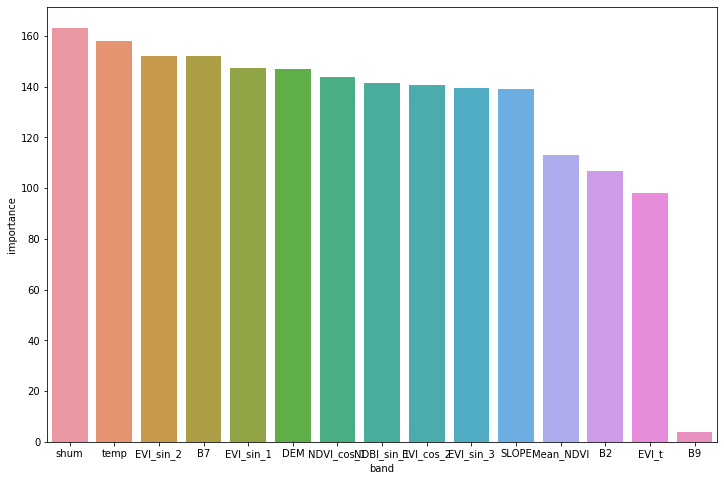

In [49]:
plt.figure(figsize=(12,8))
sns.barplot(x=gourp_mean.index ,y ='importance', data=gourp_mean )

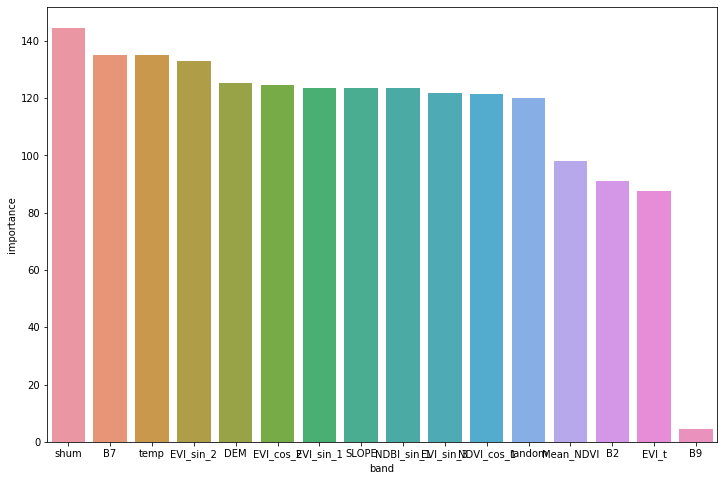

In [50]:
plt.figure(figsize=(12,8))
sns.barplot(x=gourp_mean_random.index ,y ='importance', data=gourp_mean_random )

#### Add one of the classified img to map

In [14]:
one = Classification_instances_df.iloc[0][3]
one

In [16]:
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.addLayer(one,{'min':0,'max':1},'One')
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

#### calculate the accuracy of each radomness

In [17]:
acc = []

# calculate the accuracy of differnet randomness
for i in Classificatioin_result:
    
    accuracy = Accuracy_assesment(i[4]).Stp_1_Calculate_Accuracy()
    acc.append(accuracy)
    
    key = 'Recall_built'
    print(f'{i[1]}_{i[2]}-->Recall_built:{accuracy[key]}')

Landsat_1990_1992_0-->Recall_built:95.0
Landsat_1990_1992_1-->Recall_built:93.96
Landsat_1990_1992_2-->Recall_built:94.44
Landsat_1990_1992_3-->Recall_built:94.12
Landsat_1990_1992_4-->Recall_built:93.01
Landsat_1990_1992_5-->Recall_built:94.6
Landsat_1990_1992_6-->Recall_built:93.88
Landsat_1990_1992_7-->Recall_built:94.44
Landsat_1990_1992_8-->Recall_built:94.58
Landsat_1990_1992_9-->Recall_built:94.7
Landsat_1993_1995_0-->Recall_built:94.02
Landsat_1993_1995_1-->Recall_built:94.27
Landsat_1993_1995_2-->Recall_built:93.46
Landsat_1993_1995_3-->Recall_built:95.18
Landsat_1993_1995_4-->Recall_built:94.05
Landsat_1993_1995_5-->Recall_built:93.36
Landsat_1993_1995_6-->Recall_built:94.59
Landsat_1993_1995_7-->Recall_built:94.98
Landsat_1993_1995_8-->Recall_built:93.15
Landsat_1993_1995_9-->Recall_built:94.22
Landsat_1996_1998_0-->Recall_built:94.04
Landsat_1996_1998_1-->Recall_built:94.63
Landsat_1996_1998_2-->Recall_built:93.57
Landsat_1996_1998_3-->Recall_built:93.5
Landsat_1996_1998_4-

In [21]:
# # store the acc_df to local drive
# acc_df = pd.concat([Classification_instances_df[['year','seed']],pd.DataFrame(acc)],axis=1)
# acc_df.to_csv('./Result/Classification_Accuracy.csv',index=False)

# access the acc_df
acc_df = pd.read_csv('./Result/Classification_Accuracy.csv')
acc_df

,year,seed,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built
0,Landsat_1990_1992,0,94.97,95.15,94.79,94.94,95.00
1,Landsat_1990_1992,1,94.42,94.34,94.50,94.84,93.96
2,Landsat_1990_1992,2,94.80,94.52,95.07,95.15,94.44
3,Landsat_1990_1992,3,94.81,94.23,95.41,95.50,94.12
4,Landsat_1990_1992,4,94.32,93.37,95.34,95.59,93.01
...,...,...,...,...,...,...,...
95,Landsat_2017_2019,5,91.99,91.69,92.34,93.18,90.68
96,Landsat_2017_2019,6,92.23,92.97,91.45,92.08,92.41
97,Landsat_2017_2019,7,92.47,90.97,94.00,93.94,91.06
98,Landsat_2017_2019,8,92.74,92.69,92.81,93.37,92.07


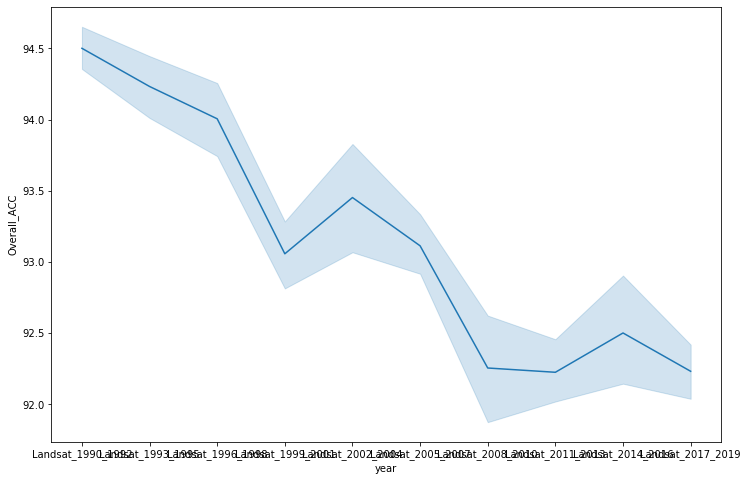

In [22]:
plt.figure(figsize=(12,8))
sns.lineplot(x='year',y='Overall_ACC',data=acc_df)

##### Export the classified_img

In [26]:
for item in Classificatioin_result:
     
    Classification_type = item[0]
    year = item[1]
    seed = item[2]
    img  = item[3]
    
    
    export_name = f'{Classification_type}_{year}_{seed}'
    
#     # export to Google Storage
#     task = ee.batch.Export.image.toCloudStorage(image          = img,
#                                                 description    = export_name,
#                                                 bucket         = 'north_china_plain',
#                                                 fileNamePrefix = export_name,
#                                                 region         = North_China_Plain.geometry().bounds(),
#                                                 scale          = 30,
#                                                 maxPixels      = int(1e13),
#                                                 skipEmptyTiles = True)
    
    #export to GEE asset
    asset_path = f'users/wangjinzhulala/North_China_Plain_Python/classification_img/Tree_50_{year}'
    
    task = ee.batch.Export.image.toAsset(   image          = img,
                                            description    = export_name,
                                            assetId        = f'{asset_path}/{export_name}',
                                            region         = North_China_Plain.geometry().bounds(),
                                            scale          = 30,
                                            maxPixels      = int(1e13)) 
    
    task.start()
    
    print(f'Exporting {export_name} successful!')

Exporting Control_1990_1992_0 successful!
Exporting Control_1990_1992_1 successful!
Exporting Control_1990_1992_2 successful!
Exporting Control_1990_1992_3 successful!
Exporting Control_1990_1992_4 successful!
Exporting Control_1990_1992_5 successful!
Exporting Control_1990_1992_6 successful!
Exporting Control_1990_1992_7 successful!
Exporting Control_1990_1992_8 successful!
Exporting Control_1990_1992_9 successful!
Exporting Control_1993_1995_0 successful!
Exporting Control_1993_1995_1 successful!
Exporting Control_1993_1995_2 successful!
Exporting Control_1993_1995_3 successful!
Exporting Control_1993_1995_4 successful!
Exporting Control_1993_1995_5 successful!
Exporting Control_1993_1995_6 successful!
Exporting Control_1993_1995_7 successful!
Exporting Control_1993_1995_8 successful!
Exporting Control_1993_1995_9 successful!
Exporting Control_1996_1998_0 successful!
Exporting Control_1996_1998_1 successful!
Exporting Control_1996_1998_2 successful!
Exporting Control_1996_1998_3 succ